## A step-by-step illustration of the algorithm
This script illustrates the steps of calculating catchmentwide erosion rates with the `riversand` package. It shows all the basic calculations performed by the functions `.process_single_catchment()`and `.process_multi_catchment()`; these functions iterate over samples and catchments and save plots and results.

Use this script for a better understanding of the algorithm, or if you want to develop your own customized script for calculating catchmentwide erosion rates.

## Setup

In [1]:
import pandas as pd
import numpy as np

import riversand
from riversand.params import units

# path to the user data
path = "./user_data"

In [2]:
rv = riversand.Riversand()
rv.add_raster('dem_utm_35m.tif', path, dtype='elevation')
rv.add_raster('toposhielding_35m.tif', path, dtype='shielding')
rv.add_raster('quartz_35m.tif', path, dtype='quartz')
rv.add_samples(data={'N':1.2e5, 'delN': 5.6e3, 'nuclide': 'Al-26'})
rv.add_samples(data={'N':1.2e5, 'delN': 1.7e4, 'nuclide': 'Al-26'}, add=True)
rv.add_samples(data={'N':2.0e4, 'delN': 9.3e2, 'nuclide': 'Be-10'}, add=True)
rv.add_catchments(fname='test_multi_catchment.shp', path=path)
rv.set_cid('name')
rv.samples # two Al-26 samples with different uncertainties on the nuclide concentration

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,5600,KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,17000,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,930,07KNSTD


In [3]:
# clip the first catchment of the shapefile (n=0)
clips = rv.clip_all_rasters(n=5)
#riversand.plot_clipped_raster(clips, fname='show')

In [4]:
# remove the quartz-free areas
clips = riversand.eliminate_quartzfree(clips)

Removed 8.4 % of the catchment as quartz-free


In [5]:
#riversand.plot_clipped_raster(clips, fname='show')
#riversand.plot_clipped_raster(clips, label='shielding', fname='show')

In [6]:
# define parameters of the calculation
bins = 100
scaling = 'LSDn'
shielding = 'topo'

In [7]:
# compute elevation statistics
topostats, summary = riversand.get_topostats(clips, bins=bins, centroid='from_clipped')
topostats.head()

,bin,elevation,shielding,area,lat,long,wt
0,700.0,749.315002,0.943678,0.245000,45.607522,7.054166,0.001690
1,800.0,859.946350,0.942219,0.388325,45.607522,7.054166,0.002678
2,900.0,947.437195,0.942153,0.711725,45.607522,7.054166,0.004909
3,1000.0,1052.943848,0.932430,0.632100,45.607522,7.054166,0.004360
4,1100.0,1154.039551,0.926303,1.084125,45.607522,7.054166,0.007478


### First sample: Al-26

In [8]:
# select a row from the sample data
i = 0 # first row 
sample_data = rv.samples.iloc[i] 

In [9]:
# use the summary of the elevation statistics to estimate a probable range of erosion rates
# minimum estimate from 1st quartile of elevations
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
E_Lo

{'St': 0.08775849056603774,
 'Lm': 0.09034716981132075,
 'LSDn': 0.09449056603773585}

In [10]:
# maximum estimate from 3rd quartile of elevations
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
E_Hi

{'St': 0.11363773584905662,
 'Lm': 0.11743018867924529,
 'LSDn': 0.12502641509433962}

In [11]:
# generate suitable initial erosion rates (scaling-specific)
#erates = riversand.guess_erates(E_Lo, E_Hi, scaling='LSDn') # cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr
erates

array([0.09449057, 0.0999335 , 0.10568997, 0.11177803, 0.11821678,
       0.12502642])

In [12]:
# perform the polynomial fitting
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
# E, delE - erosion rate and uncertainty in cm/yr
# NofE - nuclide concentrations for the inital erosion rates as obtained from the online calculator

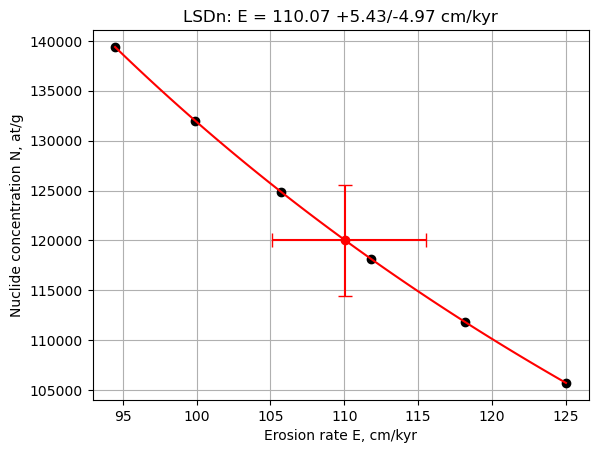

In [13]:
# plot the results
unit = 'cm/kyr'
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

- The black points are the erosion rates `erates` sent to the server and the corresponding predicted nuclide concentrations `NofE`.
- The red curve is the polynomial fit to `NofE`
- The red point and vertical error bar are the nuclide concentration of the sample `sample_data['N']` and uncertainty `sample_data['delN']`
- The horizontal error bar is the uncertainty on the erosion rate `delE` resulting from the analytics uncertainty `delN`; it depends on the shape of the function $N(E)$ and is therefore asymmetric. Use the upper value (`delE[1]`) for a more conservative estimate of the analytical uncertainty in `E`.

In [14]:
u = units[unit]
print("{} : {:.1f} +/-{:.1f} {}".format(sample_data['nuclide'], E*u, delE[1]*u, unit))

Al-26 : 110.1 +/-5.4 cm/kyr


### Second sample: Al-26 with 3x higher uncertainty

In [15]:
# select a row from the sample data
i = 1 # second row 
sample_data = rv.samples.iloc[i]

In [16]:
# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

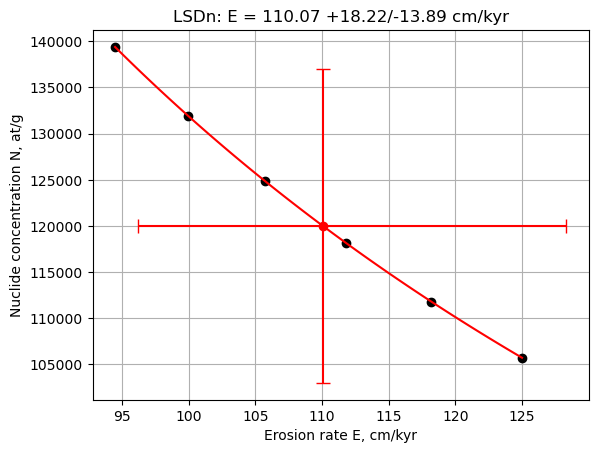

In [17]:
# perform the polynomial fitting and plot results
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

In [18]:
print("{} : {:.1f} +/-{:.1f} {}".format(sample_data['nuclide'], E*u, delE[1]*u, unit))

Al-26 : 110.1 +/-18.2 cm/kyr


### Third sample: Be-10 with factor 6 lower nuclide concentration

In [19]:
# select a row from the sample data
i = 2 # third row 
sample_data = rv.samples.iloc[i]

In [20]:
# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

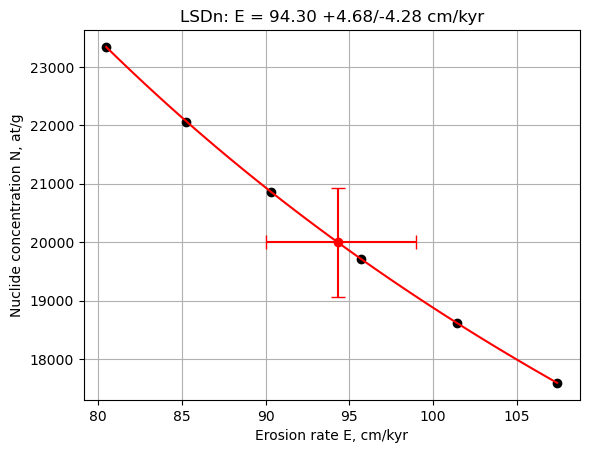

In [21]:
# perform the polynomial fitting and plot results
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

In [22]:
print("{} : {:.1f} +/-{:.1f} {}".format(sample_data['nuclide'], E*u, delE[1]*u, unit))

Be-10 : 94.3 +/-4.7 cm/kyr


In [23]:
# sample data again, for comparison
rv.samples

,name,press_flag,thickness,density,shielding,erate,year,nuclide,mineral,N,delN,standardization
0,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,5600,KNSTD
1,Test,std,0,2.65,1.0,0,2010,Al-26,quartz,120000,17000,KNSTD
2,Test,std,0,2.65,1.0,0,2010,Be-10,quartz,20000,930,07KNSTD


## Finally
The functions `.process_single_catchment()`and `.process_multi_catchment()` optimize the choice of a suitable set of initial erosion rates `erates`. You can customize the initial erosion rates, even though this is generally not necessary or even useful:

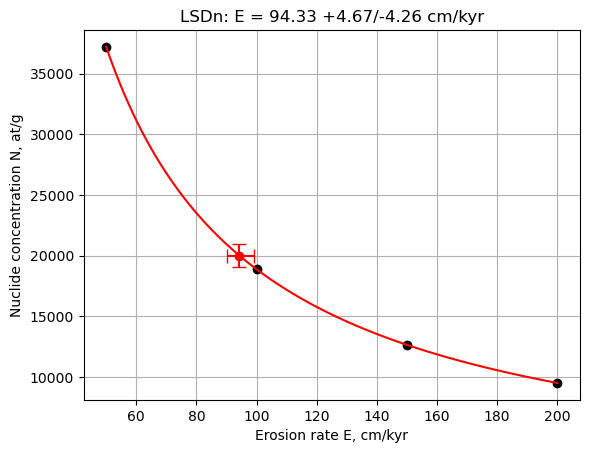

In [24]:
# (1) Custom initial erosion rates:
unit = 'cm/kyr'
erates = [0.05, 0.10, 0.15, 0.20] # cm/yr
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

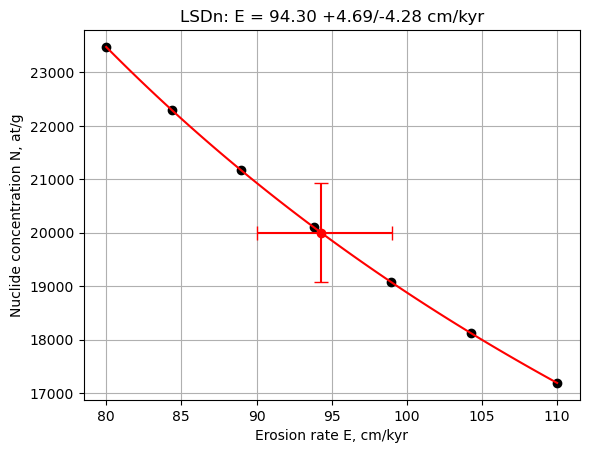

In [25]:
# (2) Using the function .guess_erates() for logarithmically distributed values
erates = riversand.guess_erates(0.08, 0.11, N=7)
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

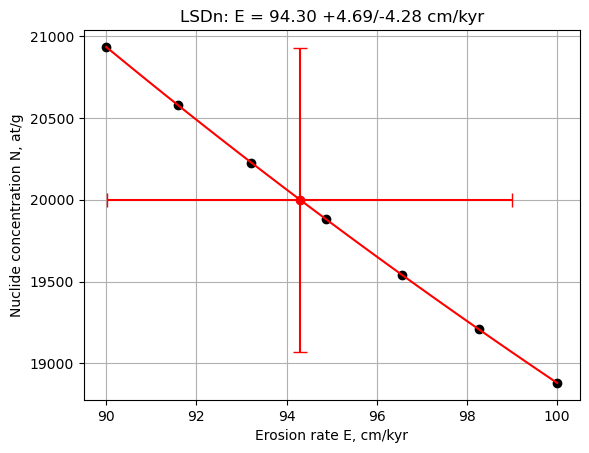

In [26]:
# (3) Using narrower brackets 
erates = riversand.guess_erates(0.09, 0.10, N=7)
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

In [27]:
# (4) Note that you may get error messages for an unsuitable choice of initial erosion rates
erates = riversand.guess_erates(0.08, 0.09, N=5)
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
err

['maxE too low']

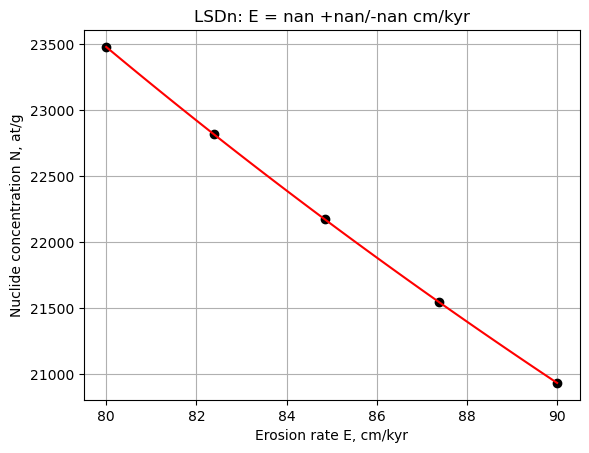

In [28]:
# erosion rate is outside of the range of NofE: nothing much to plot
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

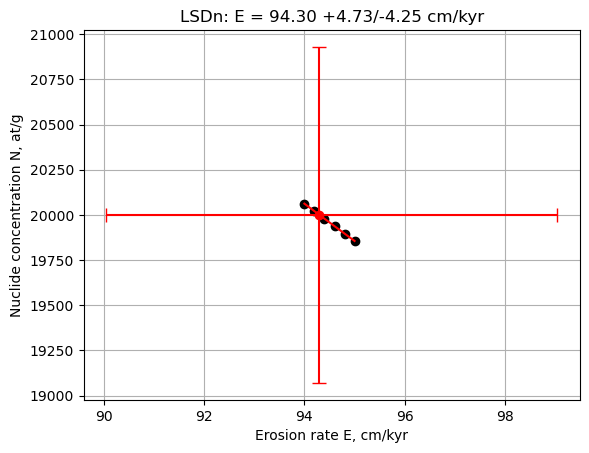

In [29]:
# (5) The estimation of delE becomes inaccurate for a very narrow range of initial erosion rates
erates = riversand.guess_erates(0.094, 0.095)
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

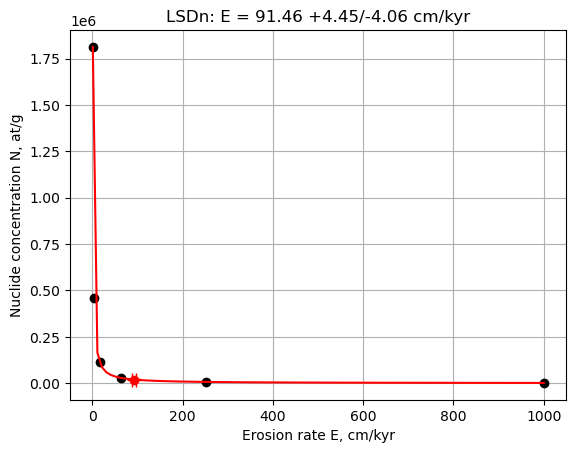

In [30]:
# (6) Unsuitable initial erosion rates may also result in a poor fit of the polynomial function
erates = riversand.guess_erates(0, 1)
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

#NRMSE = riversand.get_RMSE(NofE)/sample_data['N']

In [31]:
err

['NRMSE = 3.16e-02 suggests a poor fit of the polynomial']

### Extremely high and very low erosion rates
The algorithm becomes unstable for extremely low and extremely high nuclide concentrations; try the following code with concentrations of **N = 100 atoms/gram** or **N = 5E+7 atoms/gram**. It is, of course, highly questionable that such nuclide concentrations reflect a catchmentwide erosion rate...

In [32]:
#extremely low nuclide concentrations:
sample_data = {'N': 5e7, 'delN': 1e6}

# generate initial erosion rates
summary['elevation'] = summary['elevLo']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Lo = riversand.get_E(textline) # erosion rates in cm/yr
summary['elevation'] = summary['elevHi']
textline = riversand.get_textline(sample_data, summary, shielding=shielding)
E_Hi = riversand.get_E(textline) # erosion rates in cm/yr
erates = riversand.guess_erates(E_Lo, E_Hi, scaling=scaling) # cm/yr

unit = 'mm/kyr'
E, delE, NofE, err = (riversand.
                      poly_E_results(sample_data, topostats, 
                                     shielding=shielding, erates=erates, scaling=scaling))
riversand.plot_polyfit(E, delE, NofE, sample_data, unit=unit, fname='show')

RuntimeError: get_E() : sample appears to be saturated